/tmp/ipykernel_2917161/1894031198.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(file_path, map_location='cpu')


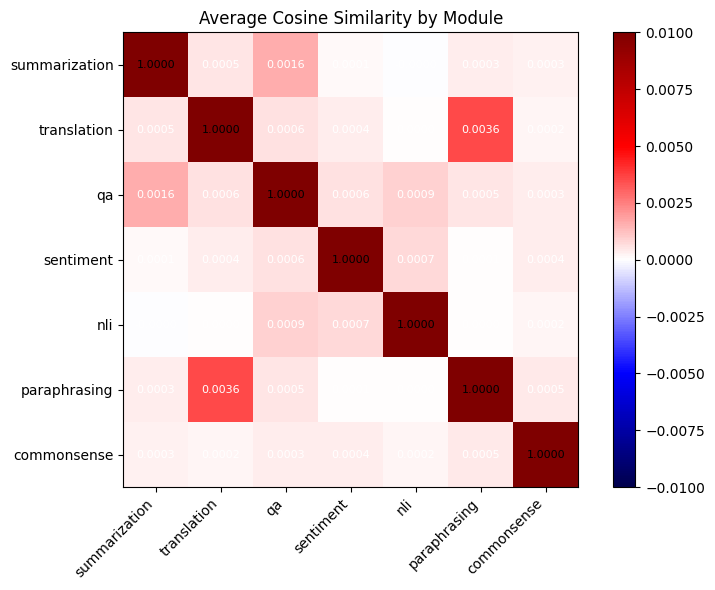

In [3]:
import torch
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import re
from collections import defaultdict

def load_lora_weights_by_module(folder_path, alpha=16, r=8):
    all_task_weights = {}
    tasks = ["summarization", "translation", "qa", "sentiment", "nli", "paraphrasing", "commonsense"]
    lora_files = [os.path.join(folder_path, f"{task}_lora.pth") for task in tasks]
    pattern = re.compile(r"([^/\\]+)_lora\.pth$")

    scaling = alpha / r

    for file_path in lora_files:
        match = pattern.search(file_path)
        if not match:
            continue
        task_name = match.group(1)

        state_dict = torch.load(file_path, map_location='cpu')
        module_dict = defaultdict(dict)

        for k, v in state_dict.items():
            if k.endswith(".A"):
                prefix = k[:-2]
                module_dict[prefix]["A"] = v.detach()
            elif k.endswith(".B"):
                prefix = k[:-2]
                module_dict[prefix]["B"] = v.detach()

        task_weights = {}
        for prefix in sorted(module_dict.keys()):
            params = module_dict[prefix]
            if "A" in params and "B" in params:
                A = params["A"].float()
                B = params["B"].float()
                delta_w = (B @ A * scaling).flatten()
                task_weights[prefix] = delta_w

        all_task_weights[task_name] = task_weights
    return all_task_weights

def compute_avg_cosine_sim_matrix_by_module(all_task_weights):
    tasks = list(all_task_weights.keys())
    matrix = np.zeros((len(tasks), len(tasks)))

    all_modules = set()
    for task_dict in all_task_weights.values():
        all_modules.update(task_dict.keys())
    all_modules = sorted(list(all_modules))

    for i, t1 in enumerate(tasks):
        for j, t2 in enumerate(tasks):
            if i==j:
                matrix[i][j] = 1.0
                continue
            sims = []
            for mod in all_modules:
                if mod in all_task_weights[t1] and mod in all_task_weights[t2]:
                    v1 = all_task_weights[t1][mod]
                    v2 = all_task_weights[t2][mod]
                    sim = torch.dot(v1, v2) / (v1.norm() * v2.norm() + 1e-8)
                    sims.append(sim.item())
            if sims:
                matrix[i][j] = np.mean(sims)
            else:
                matrix[i][j] = 0.0  
    return tasks, matrix

def plot_heatmap(task_names, sim_matrix, title="Average Cosine Similarity by Module"):
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.imshow(sim_matrix, cmap="seismic", vmin=-0.01, vmax=0.01)

    ax.set_xticks(np.arange(len(task_names)))
    ax.set_yticks(np.arange(len(task_names)))
    ax.set_xticklabels(task_names, rotation=45, ha="right")
    ax.set_yticklabels(task_names)

    for i in range(len(task_names)):
        for j in range(len(task_names)):
            text = f"{sim_matrix[i, j]:.4f}"
            color = "white" if abs(sim_matrix[i, j]) < 0.005 else "black"
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=8)

    ax.set_title(title)
    fig.colorbar(cax)
    plt.tight_layout()
    plt.show()



def compute_avg_cosine_sim_matrix_by_module_debug(all_task_weights):
    tasks = list(all_task_weights.keys())
    matrix = np.zeros((len(tasks), len(tasks)))

    all_modules = sorted(set(k for d in all_task_weights.values() for k in d))

    for i, t1 in enumerate(tasks):
        for j, t2 in enumerate(tasks):
            sims = []
            for mod in all_modules:
                if mod in all_task_weights[t1] and mod in all_task_weights[t2]:
                    v1 = all_task_weights[t1][mod]
                    v2 = all_task_weights[t2][mod]
                    sim = torch.nn.functional.cosine_similarity(v1.unsqueeze(0), v2.unsqueeze(0)).item()
                    sims.append(sim)
                    if i != j:
                        print(f"{mod} | {t1} vs {t2} → cos={sim:.4f}")
            if sims:
                matrix[i][j] = np.mean(sims)
            else:
                matrix[i][j] = 0.0
    return tasks, matrix

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def visualize_task_lora_pca(all_task_weights, max_modules=None):
    task_names = []
    feature_vectors = []

    for task, module_dict in all_task_weights.items():
        modules = sorted(module_dict.keys())
        if max_modules:
            modules = modules[:max_modules]  
        delta_list = [module_dict[m] for m in modules if m in module_dict]
        if not delta_list:
            continue
        full_vec = torch.cat(delta_list).numpy()
        task_names.append(task)
        feature_vectors.append(full_vec)

    # PCA projection
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(feature_vectors)

    # plot
    plt.figure(figsize=(8, 6))
    for i, name in enumerate(task_names):
        x, y = reduced[i]
        plt.scatter(x, y, label=name)
        plt.text(x + 0.002, y + 0.002, name, fontsize=10)
    plt.title("Task-wise LoRA Delta Weight PCA Projection")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


folder_path = "weights/Qwen2-1.5B/"  
all_task_weights = load_lora_weights_by_module(folder_path, alpha=16, r=8)
# for task, modules in all_task_weights.items():
#     print(f"{task}: {sorted(modules.keys())}")
# for task, modules in all_task_weights.items():
#     for mod_name, vec in modules.items():
#         print(f"{task} - {mod_name}: norm={vec.norm().item():.6f}")
task_names, sim_matrix = compute_avg_cosine_sim_matrix_by_module(all_task_weights)
plot_heatmap(task_names, sim_matrix)
# visualize_task_lora_pca(all_task_weights)
